NOAA dataset. Eight  features. Two classes.
50 batches of 345 instances



METHOD: Static lp as classifier
Execution time:  0.4661401359999999
Average MCC:  0.29379909011695665
Average error: 26.419200000000004
Average macro-F1: 0.6131838210093775
Average micro-F1: 0.7228
Average Accuracy:  73.5808
Standard Deviation:  3.6754824662892887
Variance:  13.509171359999993


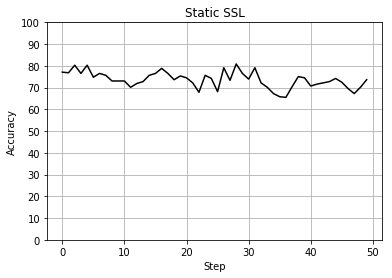

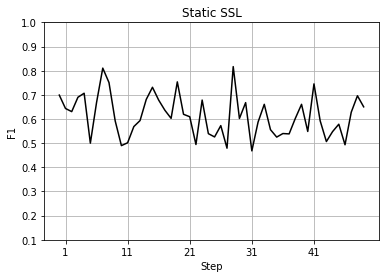

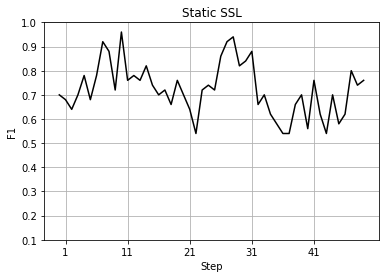




METHOD: Sliding lp as classifier
Execution time:  0.33874411899999757
Average MCC:  0.012334176636995408
Average error: 31.065799999999996
Average macro-F1: 0.40547480072308295
Average micro-F1: 0.6587999999999999
Average Accuracy:  68.9342
Standard Deviation:  4.87881628676465
Variance:  23.802848360000006


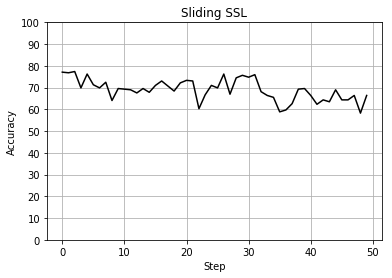

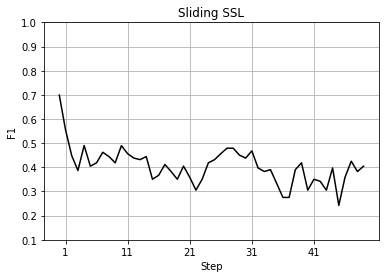

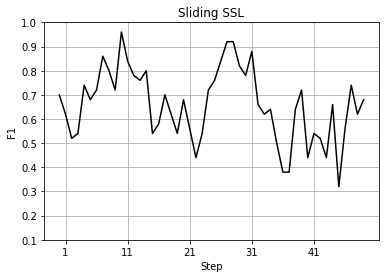




METHOD: Incremental lp as classifier
Execution time:  9.912457744000001
Average MCC:  0.19433704973474072
Average error: 28.024
Average macro-F1: 0.5315571847255185
Average micro-F1: 0.6916000000000001
Average Accuracy:  71.976
Standard Deviation:  4.122502152819329
Variance:  16.995024


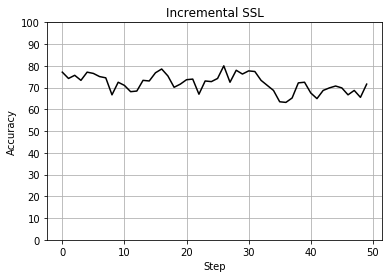

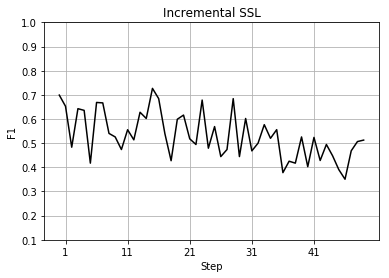

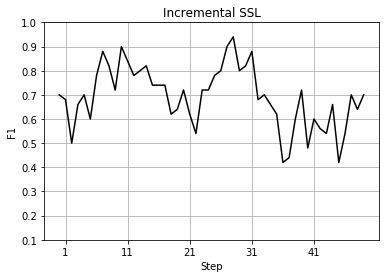




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  0.7079311690000054
Average MCC:  0.02796650273850335
Average error: 39.2752
Average macro-F1: 0.4431821628646169
Average micro-F1: 0.6092
Average Accuracy:  60.7248
Standard Deviation:  4.9800025060234665
Variance:  24.800424960000008


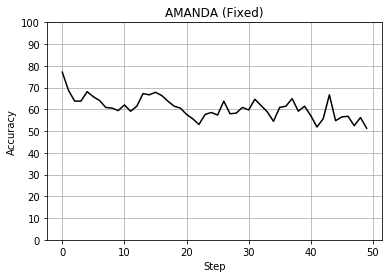

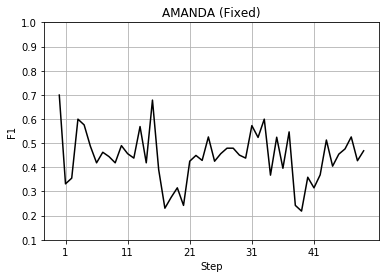

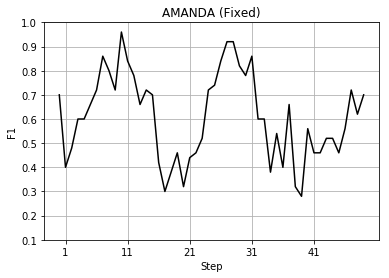




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.44 | Std keeping percentage=0.12
Execution time:  0.748556016000002
Average MCC:  0.002857142857142857
Average error: 31.390399999999985
Average macro-F1: 0.39157893915596953
Average micro-F1: 0.6555999999999998
Average Accuracy:  68.60960000000001
Standard Deviation:  4.57151132996518
Variance:  20.898715840000005


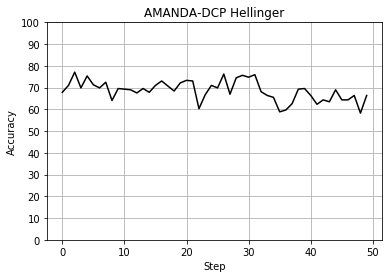

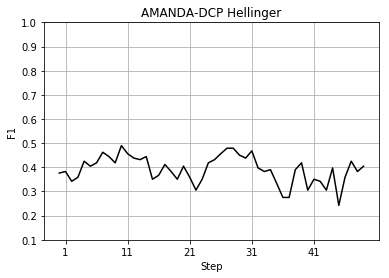

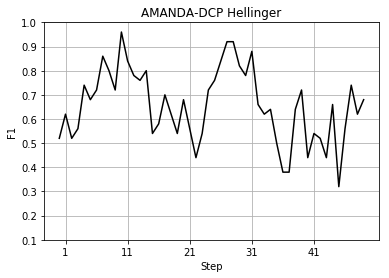




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.19 | Std keeping percentage=0.03
Execution time:  0.6666123489999976
Average MCC:  0.002857142857142857
Average error: 31.390399999999985
Average macro-F1: 0.39157893915596953
Average micro-F1: 0.6555999999999998
Average Accuracy:  68.60960000000001
Standard Deviation:  4.57151132996518
Variance:  20.898715840000005


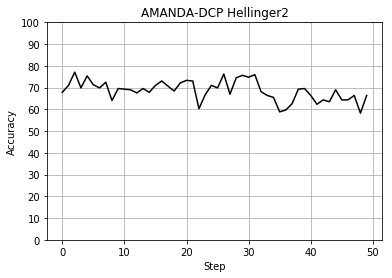

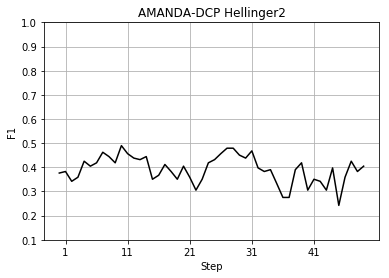

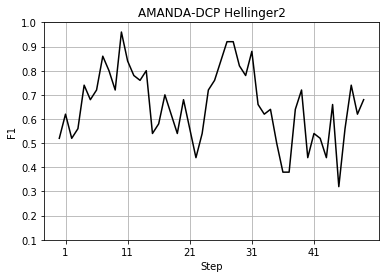




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.12 | Std keeping percentage=0.02
Execution time:  0.7533943139999977
Average MCC:  0.07129825263152377
Average error: 41.328
Average macro-F1: 0.43785876805902824
Average micro-F1: 0.6024
Average Accuracy:  58.672
Standard Deviation:  4.77384708594651
Variance:  22.789615999999988


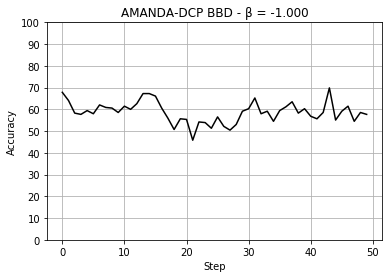

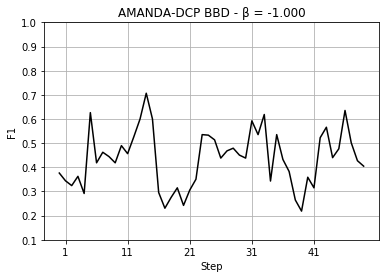

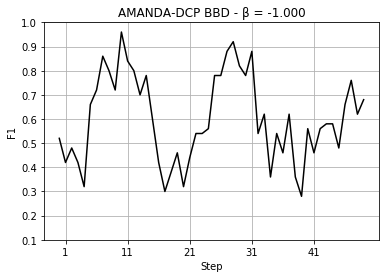




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = 2.000 | Mean keeping percentage=0.10 | Std keeping percentage=0.00
Execution time:  0.7052457400000023
Average MCC:  0.06390922847872282
Average error: 40.986
Average macro-F1: 0.4375104289054803
Average micro-F1: 0.606
Average Accuracy:  59.014
Standard Deviation:  4.410670243851834
Variance:  19.454012


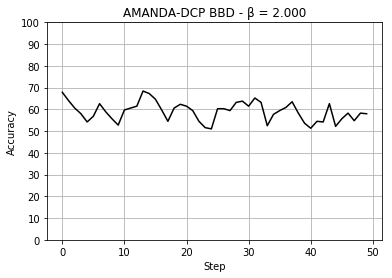

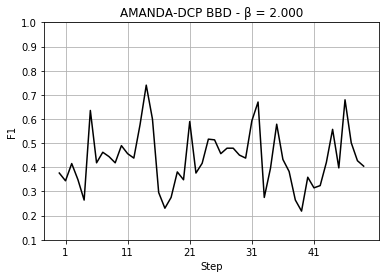

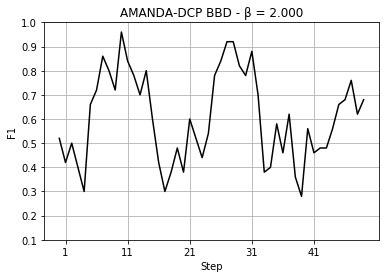




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = 3.000 | Mean keeping percentage=0.10 | Std keeping percentage=0.00
Execution time:  0.7659835540000017
Average MCC:  0.06567487385071354
Average error: 41.0498
Average macro-F1: 0.43863467010533247
Average micro-F1: 0.606
Average Accuracy:  58.9502
Standard Deviation:  4.459928470278419
Variance:  19.890961960000002


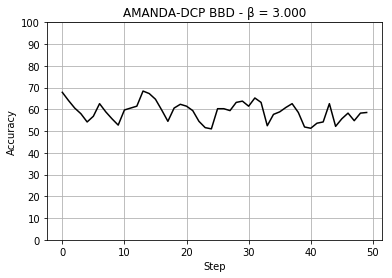

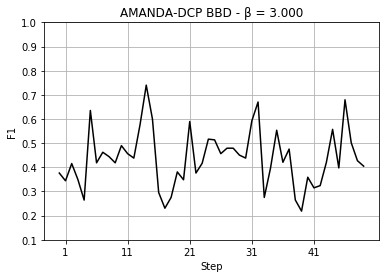

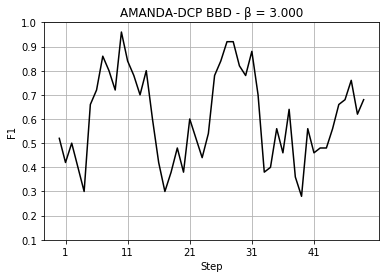




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = 10.000 | Mean keeping percentage=0.10 | Std keeping percentage=0.00
Execution time:  0.9736520410000011
Average MCC:  0.07134557997495787
Average error: 40.5744
Average macro-F1: 0.4413170193455897
Average micro-F1: 0.6092
Average Accuracy:  59.4256
Standard Deviation:  4.792315582262921
Variance:  22.96628864


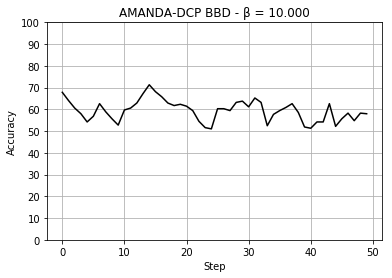

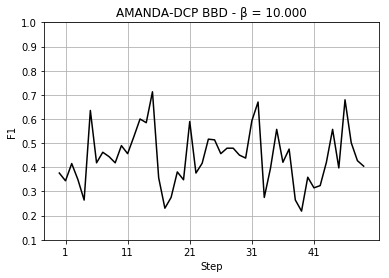

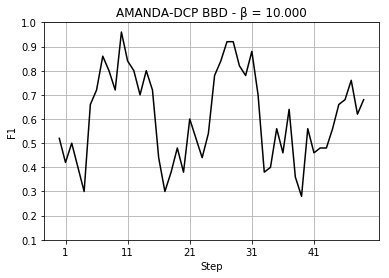

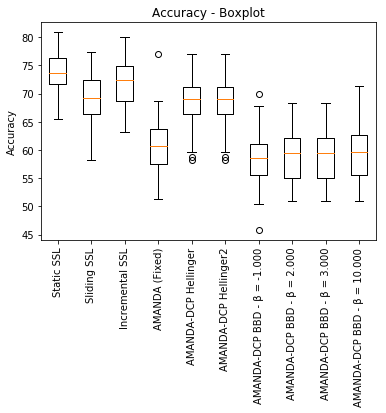

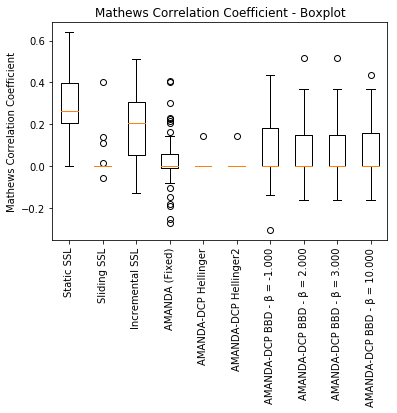

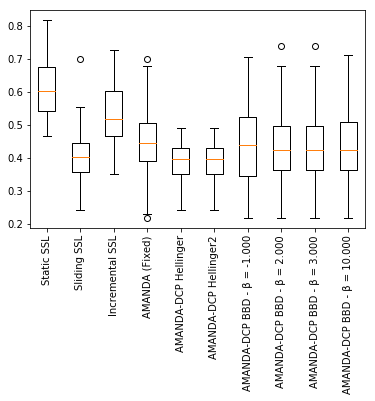

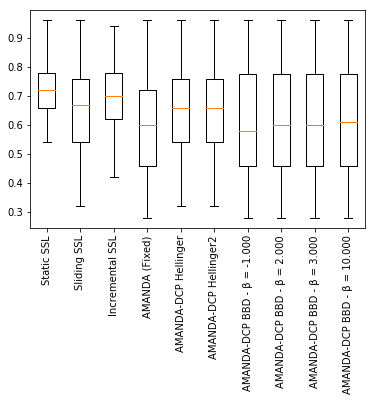

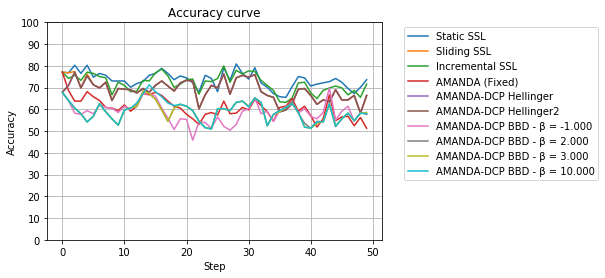

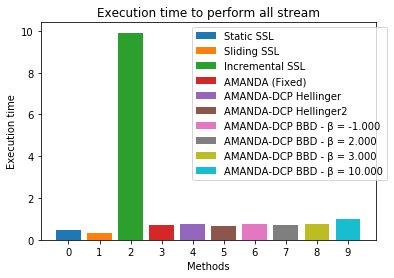

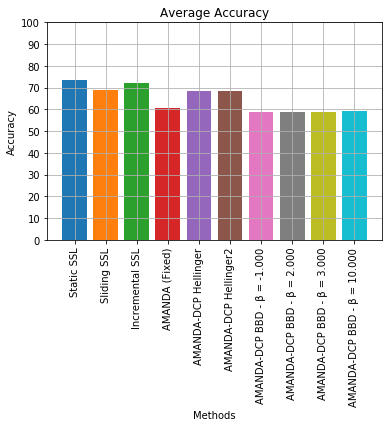

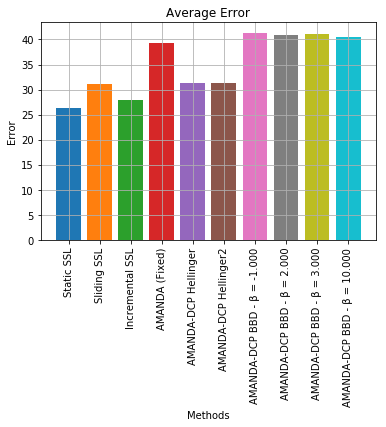

Pos 3 - Error reduction (Sliding SSL):-6.314962598938843
Pos 2 - Error reduction (Incremental SSL):-2.181003740106111
Pos 6 - Error reduction (AMANDA (Fixed)):-17.471949204140206
Pos 4 - Error reduction (AMANDA-DCP Hellinger):-6.756110289640752
Pos 4 - Error reduction (AMANDA-DCP Hellinger2):-6.756110289640752
Pos 10 - Error reduction (AMANDA-DCP BBD - β = -1.000):-20.261807428024703
Pos 8 - Error reduction (AMANDA-DCP BBD - β = 2.000):-19.79701226406888
Pos 9 - Error reduction (AMANDA-DCP BBD - β = 3.000):-19.88371966599982
Pos 7 - Error reduction (AMANDA-DCP BBD - β = 10.000):-19.237627207097496


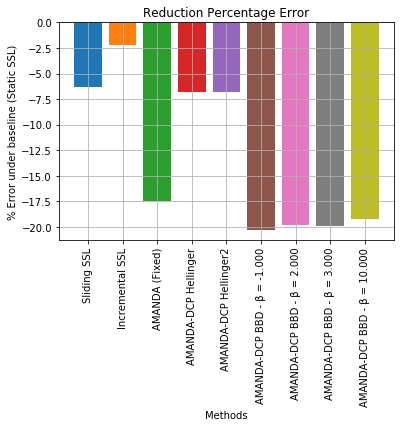

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])
import psutil
import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version
'''
from methods import prequential_amanda_fixed
from methods import prequential_amanda_dynamic
from methods import prequential_static_classifier
from methods import prequential_deslizante_LN
from methods import prequential_incremental_LN
from methods import prequential_compose_gmm_version
'''


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 50
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = True
    externalResults = []
    plot_animation = False
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadNOAADataset(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))
    
    # Static SSL
    experiments[0] = Experiment(static_classifier, 2, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
        
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 2, 0.7, "kde", sslClassifier)
    
     # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 5, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 5, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    betas = [-1, 2, 3, 10]
    bestK = [5, 5, 5, 5]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
     # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 5, None, "kde", sslClassifier, 'HDDDM')
    
    '''
    # memory usage
    #process = psutil.Process(os.getpid())
    
    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    #experiments[4] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier)
    
    #print("Memory:", process.memory_info().rss)

    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 8)
    
    
    #prequential evaluation
    steps = 10
    dataValues, dataLabels = dataValues[:labeledData], dataLabels[:labeledData]
    labeledData = int(0.05*len(dataLabels))
    experiments[0] = Experiment(prequential_static_classifier, 8, clfName=sslClassifier)
    experiments[1] = Experiment(prequential_deslizante_LN, 8, clfName=sslClassifier)
    experiments[2] = Experiment(prequential_incremental_LN, 8, clfName=sslClassifier)
    experiments[3] = Experiment(prequential_amanda_fixed, 8, 0.7, "kde", sslClassifier)
    experiments[4] = Experiment(prequential_amanda_dynamic, 6, None, "kde", clfName=sslClassifier)
    experiments[5] = Experiment(prequential_compose_gmm_version, 8, 0.7)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'noaa', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    '''
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    
    
    

if __name__ == "__main__":
    main()